In [1]:
!apt install swig
!pip install box2d box2d-kengz
!pip install comet_ml

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  swig3.0
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 39 not upgraded.
Need to get 1,100 kB of archives.
After this operation, 5,822 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig3.0 amd64 3.0.12-1 [1,094 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig amd64 3.0.12-1 [6,460 B]
Fetched 1,100 kB in 0s (10.4 MB/s)
Selecting previously unselected package swig3.0.
(Reading database ... 144579 files and directories currently installed.)
Preparing to unpack .../swig3.0_3.0.12-1_amd64.deb ...
Unpac

In [2]:
#from comet_ml import Experiment
#experiment = Experiment(api_key="sKDjRubwE0QvjkpJ6dmzVEwnp", project_name="dqn-lunarlander", workspace="johansamir")

import random
import sys
from time import time
from collections import deque, defaultdict, namedtuple
import numpy as np
import pandas as pd
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gym
import matplotlib.pyplot as plt
import os
%matplotlib inline

#plt.style.use('seaborn')
plt.style.use('fivethirtyeight')


In [3]:
env = gym.make('LunarLander-v2')
env.seed(0)

[0]

In [4]:
# inspect action space and state space
print(env.action_space)
print(env.action_space.n)
print(env.observation_space)


#0– Do nothing
#1– Fire left engine
#2– Fire down engine
#3– Fire right engine

#Position X
#Position Y
#Velocity X
#Velocity Y
#Angle
#Angular Velocity
#Is left leg touching the ground: 0 OR 1
#Is right leg touching the ground: 0 OR 1


Discrete(4)
4
Box(8,)


In [5]:
state = env.reset() # I have to call this sentecen before env.step(action)
actions = range(env.action_space.n)
print('action_range:',actions)
action = np.random.choice(actions)
print('action:', action)
state, reward, done, info = env.step(action)
print('state:', state, '\nreward:', reward, '\ndone:', done, '\ninfo:',info)

action_range: range(0, 4)
action: 1
state: [-1.2460708e-03  1.4154155e+00 -6.7727223e-02  8.7033525e-02
  2.9421085e-03  4.5001026e-02  0.0000000e+00  0.0000000e+00] 
reward: 1.291988827466356 
done: False 
info: {}


In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device:', device)

device: cuda:0


In [7]:
# Here we declare that QNetwork class inherits from the nn.Module() class
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed):
        """
        Build a fully connected neural network
        
        Parameters
        ----------
        state_size (int): State dimension
        action_size (int): Action dimension
        seed (int): random seed
        """
        super(QNetwork, self).__init__()
        #super() gives you access to methods in a superclass from the subclass that inherits from it. 
        #super() can also take two parameters: the first is 
        #the subclass, and the second parameter is an object that is an instance of that subclass
        self.seed = torch.manual_seed(seed)
        #the results will be reproducible

        self.fc1 = nn.Linear(state_size, 32) #Applies a linear transformation to the incoming data
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, action_size)  
        
    def forward(self, x):
        """Forward pass"""
        x = F.relu(self.fc1(x)) #Applies the rectified linear unit function element-wise
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        # Try to use  Advantage function
        
        return x        

In [8]:
class ReplayBuffer:
    def __init__(self, buffer_size, batch_size, seed):
        """
        Replay memory allow agent to record experiences and learn from them
        
        Parametes
        ---------
        buffer_size (int): maximum size of internal memory
        batch_size (int): sample size from experience
        seed (int): random seed
        """
        self.batch_size = batch_size
        self.seed = random.seed(seed)
        self.memory = deque(maxlen=buffer_size)# internal memory (deque)
        #Once a bounded length deque is full, when new items are added, 
        #a corresponding number of items are discarded from the opposite end.
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        #factory function for creating tuple subclasses with named fields
        #Returns a new tuple subclass named Experience. The new subclass is used to create tuple-like objects
        #that have fields accessible by attribute lookup as well as being indexable and iterable
    
    def add(self, state, action, reward, next_state, done):
        """Add experience"""
        experience = self.experience(state, action, reward, next_state, done)
        self.memory.append(experience)
                
    def sample(self):
        """ 
        Sample randomly and return (state, action, reward, next_state, done) tuple as torch tensors 
        """
        experiences = random.sample(self.memory, k=self.batch_size)
        
        # Convert to torch tensors
        #Converting NumPy Array to Torch Tensor
        #is None -> is used specifically to check if a variable is “valid” (has been set to some useful value). 
        states = torch.from_numpy(np.vstack([experience.state for experience in experiences if experience is not None])).float().to(device)
        # Actions are used as indices, must be LongTensor (QUEST)
        actions = torch.from_numpy(np.vstack([experience.action for experience in experiences if experience is not None])).long().to(device)        
        rewards = torch.from_numpy(np.vstack([experience.reward for experience in experiences if experience is not None])).float().to(device)        
        next_states = torch.from_numpy(np.vstack([experience.next_state for experience in experiences if experience is not None])).float().to(device)  
        # Convert done from boolean to int
        dones = torch.from_numpy(np.vstack([experience.done for experience in experiences if experience is not None]).astype(np.uint8)).float().to(device)        
        
        return (states, actions, rewards, next_states, dones)
        
    def __len__(self):
        return len(self.memory)

In [9]:
# Copying the hyperparameters again here, for reference 

BUFFER_SIZE = int(1e5) # Replay memory size
BATCH_SIZE = 64         # Number of experiences to sample from memory
GAMMA = 0.99            # Discount factor
TAU = 1e-3              # Soft update parameter for updating fixed q network
LR = 1e-4               # Q Network learning rate
UPDATE_EVERY = 4        # How often to update Q network

MAX_EPISODES = 1400  #2000 Max number of episodes to play
MAX_STEPS = 1000 #1000     # Max steps allowed in a single episode/play
ENV_SOLVED = 200     # MAX score at which we consider environment to be solved
PRINT_EVERY = 100    # How often to print the progress

# Epsilon schedule

EPS_START = 1.0      # Default/starting value of eps
EPS_DECAY = 0.995    # Epsilon decay rate
EPS_MIN = 0.01 

In [10]:
class DQNAgent:
    def __init__(self, state_size, action_size, seed):
        """
        DQN Agent interacts with the environment, 
        stores the experience and learns from it
        
        Parameters
        ----------
        state_size (int): Dimension of state
        action_size (int): Dimension of action
        seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        # Initialize Q and Fixed Q networks
        self.q_network = QNetwork(state_size, action_size, seed).to(device)
        self.fixed_network = QNetwork(state_size, action_size, seed).to(device)
        #optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        self.optimizer = optim.Adam(self.q_network.parameters())
        # Initiliase memory 
        self.memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE, seed)
        self.timestep = 0
        
    
    def step(self, state, action, reward, next_state, done):
        """
        Update Agent's knowledge
        
        Parameters
        ----------
        state (array_like): Current state of environment
        action (int): Action taken in current state
        reward (float): Reward received after taking action 
        next_state (array_like): Next state returned by the environment after taking action
        done (bool): whether the episode ended after taking action
        """
        self.memory.add(state, action, reward, next_state, done)
        self.timestep += 1
        if self.timestep % UPDATE_EVERY == 0:
            if len(self.memory) > BATCH_SIZE:
                sampled_experiences = self.memory.sample()
                self.learn(sampled_experiences)
        
    def learn(self, experiences):
        """
        Learn from experience by training the q_network 
        
        Parameters
        ----------
        experiences (array_like): List of experiences sampled from agent's memory
        """
        states, actions, rewards, next_states, dones = experiences
        # Get the action with max Q value
        #tensor.detach() creates a tensor that shares storage with tensor that does not require grad
        #It detaches the output from the computational graph. So no gradient will be backpropagated along this variable.

        action_values = self.fixed_network(next_states).detach()
        # Notes
        # tensor.max(1)[0] returns the values, tensor.max(1)[1] will return indices
        # unsqueeze operation --> np.reshape
        # Here, we make it from torch.Size([64]) -> torch.Size([64, 1])
        #Returns the maximum value of all elements in the input tensor.
        max_action_values = action_values.max(1)[0].unsqueeze(1)
        
        # If done just use reward, else update Q_target with discounted action values
        # The parameters from the previous iteration θi−1 are held fixed for target
        Q_target = rewards + (GAMMA * max_action_values * (1 - dones))

        #For q_network (Q_expected) the parameters w of the online network are updated by sampling gradients from 
        #mini batches of past transition tuples
        Q_expected = self.q_network(states).gather(1, actions)
        
        # Calculate loss
        # The difference between the two sides of the equality is known as the temporal difference error, δ
        loss = F.mse_loss(Q_expected, Q_target)  # I do not undertand?
        #loss = F.mse_loss(Q_target,Q_expected) #Change [Joh+]

        # According to:
        # self.optimizer = optim.Adam(self.q_network.parameters()) ->  q_network update it weight each iteration

        self.optimizer.zero_grad()
        # backward pass
        loss.backward()
        # update weights
        self.optimizer.step()
        
        # Update fixed weights (ecery cte times update the fixed weights of the target network)
        self.update_fixed_network(self.q_network, self.fixed_network)
        
    def update_fixed_network(self, q_network, fixed_network):
        #copying weights from Q network using TAU param
        #net1.load_state_dict(net2.state_dict())
        #I want to copy a part of the weight from one network to another.
        #Using something like polyak averaging
        #Example:
        #weights_new = k*weights_old + (1-k)*weights_new
        #https://discuss.pytorch.org/t/copying-weights-from-one-net-to-another/1492/16
        #https://github.com/navneet-nmk/pytorch-rl/blob/master/train_ddpg.py
        #file:///tmp/mozilla_johan0/MLMU-DRL.pdf
        #https://stackoverflow.com/questions/51102220/net-does-not-change-weights-during-training-pytorch
        #https://medium.com/@markus.x.buchholz/deep-reinforcement-learning-introduction-deep-q-network-dqn-algorithm-fb74bf4d6862
        #https://cugtyt.github.io/blog/rl-notes/201807201658.html

        """
        Update fixed network by copying weights from Q network using TAU param
        
        Parameters
        ----------
        q_network (PyTorch model): Q network
        fixed_network (PyTorch model): Fixed target network
        """
        # the weight of fixed_network q netwok (Target)
        # copy from q network (expected) to fixed net
        #for source_parameters, target_parameters in zip(q_network.parameters(), fixed_network.parameters()):
        #    target_parameters.data.copy_(TAU * source_parameters.data + (1.0 - TAU) * target_parameters.data)
        
        # Add [Joh+]
        #self.target_net.load_state_dict(self.online_net.state_dict())
        self.fixed_network.load_state_dict(self.q_network.state_dict())
        
        
    def act(self, state, eps=0.0):
        """
        Choose the action
        
        Parameters
        ----------
        state (array_like): current state of environment
        eps (float): epsilon for epsilon-greedy action selection
        """
        rnd = random.random()
        if rnd < eps:
            return np.random.randint(self.action_size)
        else:
            state = torch.from_numpy(state).float().unsqueeze(0).to(device)
            # set the network into evaluation mode 
            self.q_network.eval()
            with torch.no_grad():
                action_values = self.q_network(state)
            # Back to training mode
            self.q_network.train()
            #from tensor to numpy: I can retrieve a tensor held by the Variable, using the .data attribute. 
            #Then, this should work: var.data.numpy().
            action = np.argmax(action_values.cpu().data.numpy())
            return action    
        
    def checkpoint(self, filename):
        torch.save(self.q_network.state_dict(), filename)

In [11]:
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
dqn_agent = DQNAgent(state_size, action_size, seed=0)

In [12]:
start = time()
scores = []
# Maintain a list of last 100 scores
scores_window = deque(maxlen=100)
eps = EPS_START
running_reward = None
running_rewards = []

for episode in range(1, MAX_EPISODES + 1): # from 1 to  MAX_EPISODES + 1, 0 simulation was executed above.
    state = env.reset()
    score = 0
    for t in range(MAX_STEPS):
        # Evaluate the network to get an action (At the beginning I will get random actions)
        # -- Random or evaluating self.q_network(state)
        action = dqn_agent.act(state, eps) 
        # Evaluate the action in the environment
        next_state, reward, done, info = env.step(action)
        # Update Agent's knowledge
        # -Add experience in the meemory
        # -Update Q network EVERY 4 Steps if the len of the memory is > Batch Size
        #   -- sampled_experiences using random.sample [Batch_size,5]
        #   -- Learn from experience by training the q_network 
        #     --- Calculate q_network (Q_expected) - fixed_network (Q_target)*GAMMA +R
        #     ---mse_loss -> update weights
        #       ---- Update fixed weights (Update fixed network by copying weights from Q network using TAU param)
        #       ----TAU = 1e-3 -> Soft update parameter for updating fixed q network
        # After Updating weight if its neccesary finish the dqn_agent      
        dqn_agent.step(state, action, reward, next_state, done)
        state = next_state        
        score += reward        
        if done: # Break for if the environment is the task is resolved
            break
            
        eps = max(eps * EPS_DECAY, EPS_MIN) #set the exploration/ explotation value for taking an action
        if episode % PRINT_EVERY == 0:
            mean_score = np.mean(scores_window)
            print('\r Progress {}/{}, average score:{:.2f}'.format(episode, MAX_EPISODES, mean_score), end="")
        if score >= ENV_SOLVED:
            mean_score = np.mean(scores_window)
            print('\rEnvironment solved in {} episodes, average score: {:.2f}'.format(episode, mean_score), end="")
            sys.stdout.flush()
            #dqn_agent.checkpoint('solved_200.pth')
            #dqn_agent.checkpoint(path)
            break
            
    scores_window.append(score) # I am not sure if it has been used.
    scores.append(score)
    running_reward = np.mean(scores[-100:])
    running_rewards.append(running_reward) 
    
end = time()    
print('Took {} seconds'.format(end - start))

 Progress 1400/1400, average score:195.71Took 2185.818783521652 seconds


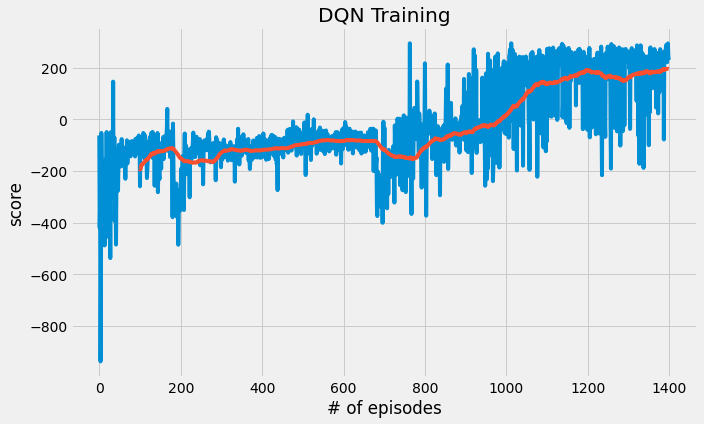

In [13]:
plt.figure(figsize=(10,6))
plt.plot(scores)
# A bit hard to see the above plot, so lets smooth it (red)
plt.plot(pd.Series(scores).rolling(100).mean())
plt.title('DQN Training')
plt.xlabel('# of episodes')
plt.ylabel('score')
plt.show()

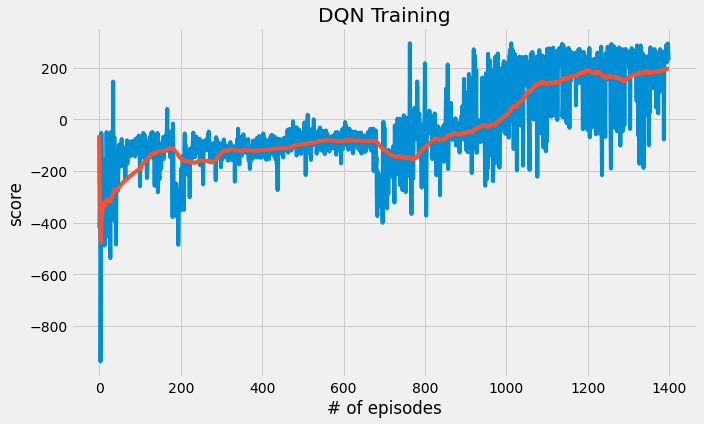

In [14]:
plt.figure(figsize=(10,6))
plt.plot(scores)
plt.plot(running_rewards)
plt.title('DQN Training')
plt.xlabel('# of episodes')
plt.ylabel('score')
plt.show()

In [15]:
for i in range(10):
    score = 0
    state = env.reset()
    while True:
        action = dqn_agent.act(state)
        next_state, reward, done, info = env.step(action)
        state = next_state        
        score += reward        
        if done:
            break
    print('episode: {} scored {}'.format(i, score))

episode: 0 scored 240.0734733287385
episode: 1 scored 231.98534899229807
episode: 2 scored 217.52355065024295
episode: 3 scored 214.96997566716828
episode: 4 scored 236.83677163889368
episode: 5 scored 234.77051865301223
episode: 6 scored 219.8815336306954
episode: 7 scored 248.39795701392052
episode: 8 scored 216.55103978041524
episode: 9 scored 188.95223670963858


In [16]:
env.close()